id: 0, event_type: started_school
id: 1, event_type: finished_school
id: 2, event_type: started_work
id: 3, event_type: new_family_member
id: 4, event_type: bought_house
id: 5, event_type: got_married
----------------------------


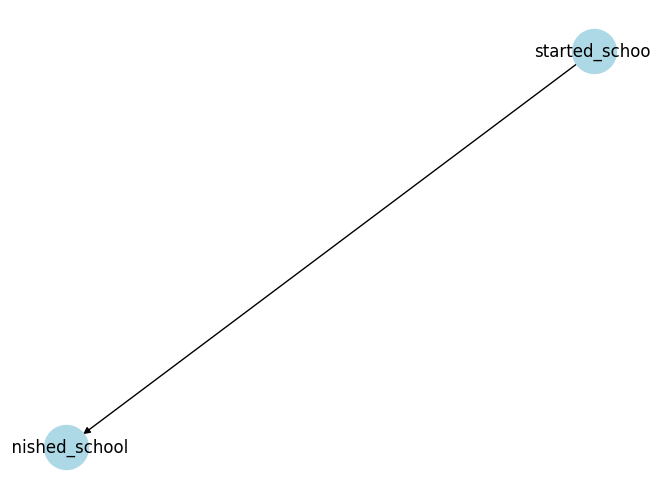

In [7]:

from classes.event_nodes import EventNodes
from classes.event_graph import EventGraph

en = EventNodes()
en.nodes
en.print_nodes()

nodes = en.nodes

print("----------------------------")

eg = EventGraph()
eg.add_node(nodes["started_school"])
eg.add_node(nodes["finished_school"])
eg.add_edge(nodes["started_school"], nodes["finished_school"])
eg.visualize()